In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

Text(0.5, 1.0, 'Stock Price of Google[2006-2018]')

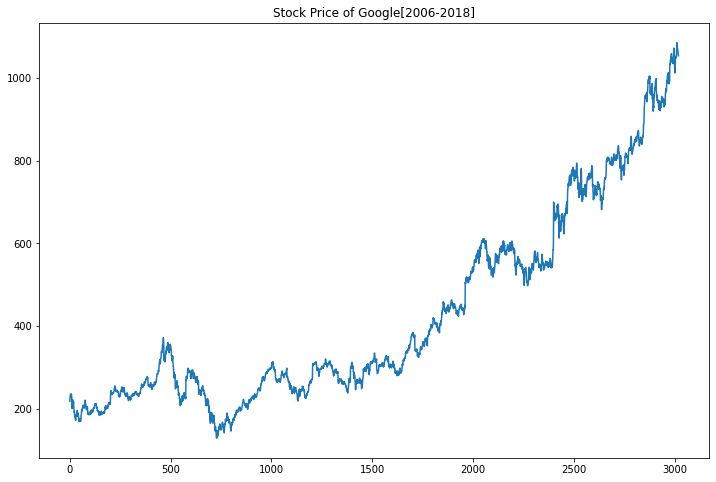

In [2]:
df = pd.read_csv('/kaggle/input/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv')
df.drop(['Open','High','Low','Volume','Name','Date'], axis=1, inplace=True)
plt.figure(figsize=(12,8))
df['Close'].plot()
plt.title('Stock Price of Google[2006-2018]')

### It is clear from graph that our series is non-stationary and to confirm it let's use Augmented Dickey Fuller Test.
### The null hypothesis of ADF test is that series is non-stationary. So, if p-value of the test is less than significance level(0.05) than we reject null hypothesis.

In [3]:
check = adfuller(df['Close'])
print('test_statics',check[0])
print('p_value',check[1])

test_statics 1.3224241360302191
p_value 0.9967315857800989


### The p-value in our case is almost equal to 1. So we conclude that series is Non-Stationary. To convert this series into stationary we will use differencing.

Text(0.5, 1.0, 'Stationary series after lag difference.')

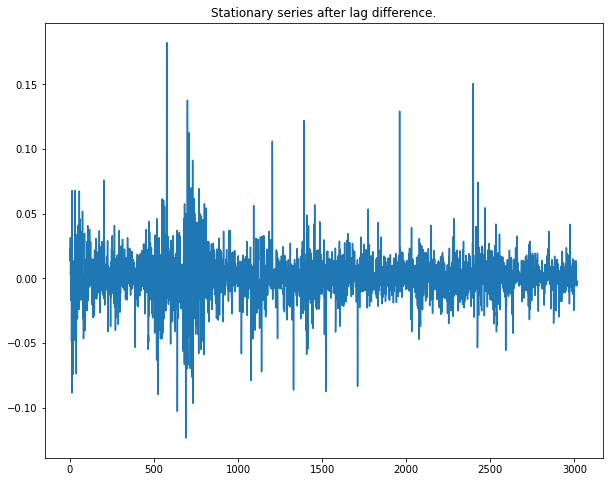

In [4]:
# First converting into log values that using pandas difference funciton.
df['log'] = np.log(df['Close'])
df['diff'] = df['log'].diff(periods=1)
plt.figure(figsize=(10,8))
df['diff'].plot()
plt.title('Stationary series after lag difference.')

In [5]:
# Let's run ADF test again on differenced sereis:
check = adfuller(df['diff'].dropna())
print('test_statics',check[0])
print('p_value',check[1])

test_statics -55.47986059461534
p_value 0.0


In [6]:
# Training and test set: (90 %)
train = df['diff'][1:int(len(df)*.9)]
test = df['diff'][len(train): ]

## Using ARIMA:

                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                 2716
Model:                 ARIMA(0, 2, 2)   Log Likelihood                6886.560
Date:                Sun, 30 Jan 2022   AIC                         -13767.121
Time:                        18:48:43   BIC                         -13749.402
Sample:                             0   HQIC                        -13760.715
                               - 2716                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.0000      0.538     -3.718      0.000      -3.054      -0.946
ma.L2          1.0000      0.538      1.859      0.063      -0.054       2.054
sigma2         0.0004      0.000      1.861      0.0

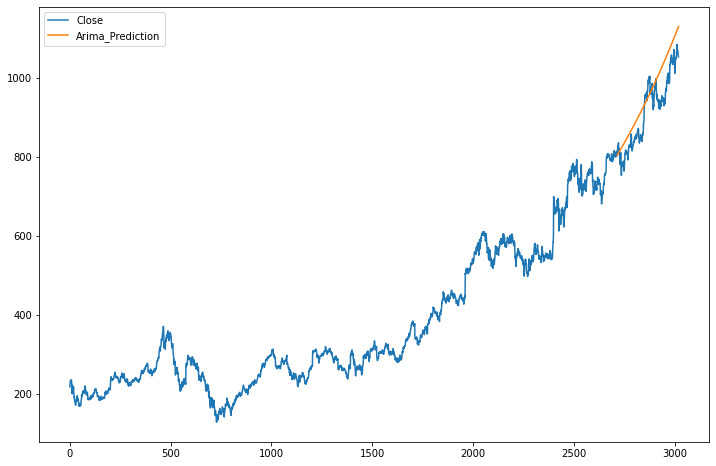

In [7]:
# Build model:
model = ARIMA(train, order=(0,2,2))
model_fit = model.fit()
print(model_fit.summary())

# Forecast:
result_arima = model_fit.predict(len(train),3019)

# Reversing into stock price:
df['Arima_Prediction'] = np.nan  # creating an empty column.
result_arima = np.r_[df['log'][2714], result_arima].cumsum()
# opposite of log is exponential()
result_arima = np.exp(result_arima)
# Assigning final predicted values to dataframe.
df['Arima_Prediction'][2714: ] = result_arima

# Plot
plt.figure(figsize=(12,8))
df['Close'].plot()
df['Arima_Prediction'].plot()
plt.legend()

In [8]:
print('Mean Absolute Percentage Error(MAPE):',
      np.mean(np.abs(result_arima - df['Close'][2714:])/np.abs(df['Close'][2714:])))

Mean Absolute Percentage Error(MAPE): 0.05089793575068428


### Let us predict stock price considering seasonality.

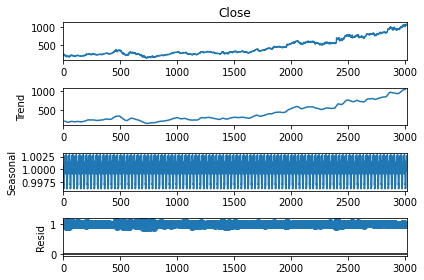

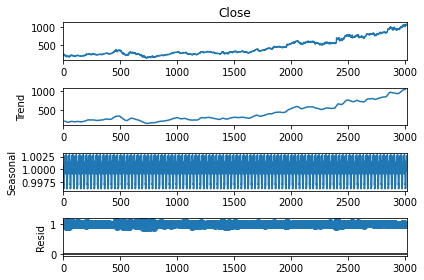

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonality = seasonal_decompose(df['Close'], model='multiplicative',period=30)
seasonality.plot()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                                diff   No. Observations:                 2716
Model:             SARIMAX(0, 2, 1)x(2, 1, [], 12)   Log Likelihood                5551.149
Date:                             Sun, 30 Jan 2022   AIC                         -11094.299
Time:                                     18:49:02   BIC                         -11070.692
Sample:                                          0   HQIC                        -11085.762
                                            - 2716                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9984      0.025    -40.571      0.000      -1.047      -0.950
ar.S.L12      -0.6463      

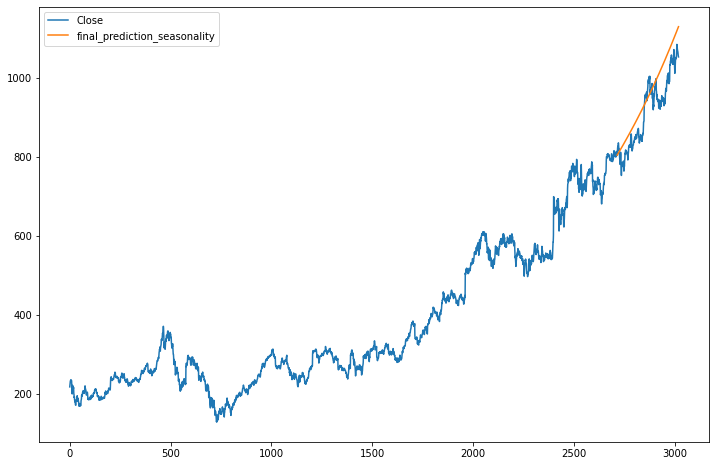

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_season = SARIMAX(train, order=(0,2,1),seasonal_order=(2,1,0,12))
model_season = model_season.fit(disp=False)
print(model_season.summary())

# Forecase:
seasonality_result = model_fit.predict(len(train),3019)

# Reversing to Original stock Price using cumsum():
df['final_prediction_seasonality'] = np.nan  # creating an empty column.
final_result_season = np.r_[df['log'][2714], seasonality_result].cumsum()
# opposite of log is exponential()
final_result_season = np.exp(final_result_season)
# Assigning final predicted values to dataframe.
df['final_prediction_seasonality'][2714: ] = final_result_season

# Plot:
plt.figure(figsize=(12,8))
df['Close'].plot()
df['final_prediction_seasonality'].plot()
plt.legend()
#df['forecast_sar'] = model_fit.predict(len(train),3019)
#df[['Close','forecast_sar']].plot(figsize=(15,8))

In [11]:
print('Mean Absolute Percentage Error(MAPE):',
      np.mean(np.abs(final_result_season - df['Close'][2714:])/np.abs(df['Close'][2714:])))

Mean Absolute Percentage Error(MAPE): 0.05089793575068428
